In [158]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
all_stopwords = stopwords.words('english')

In [160]:
dataset = pd.read_csv('IMDB Dataset.csv')

In [161]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [162]:
dataset.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

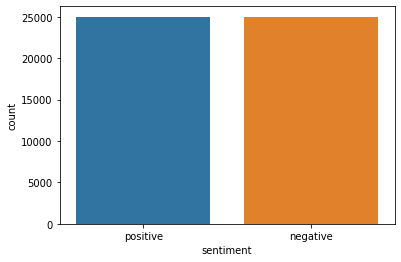

In [163]:
sns.countplot(x='sentiment', data=dataset)

In [164]:
reviews = dataset['review']
labels = dataset['sentiment']
print(len(reviews), len(labels))

50000 50000


In [157]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
all_stopwords = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Preprocessing

In [165]:
## Text Preprocessing Function

def text_preprocessing(text):
  PS = PorterStemmer()
  lemmatizer = WordNetLemmatizer() 
  ## Remove HTML Tags
  text = text.apply(lambda x: re.sub(r'<.*?>', "", x)) 
  ## Remove URL
  text = text.apply(lambda x: re.sub(r"http\S+", "", x))
  ## Remove non-alphanumeric 
  text = text.apply(lambda x: re.sub('[^a-zA-Z]', " ", x))
  ## Remove stopwords
  text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))
  #text = text..apply(lambda x: ' '.join([PS.stem(word) for word in x.split()]))
  ## Apply Lemmatization
  text = text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
  ## Perform lowercase
  text = text.apply(lambda x: x.lower())

  return text


In [166]:
processed_reviews = text_preprocessing(reviews)

In [167]:
# Print avg length of sentence
avg_sent_length= processed_reviews.apply(len).mean()
print('avg length of sentences :',avg_sent_length)

avg length of sentences : 841.0462


# Naive Bayes classifier

In [168]:
## Find the index of the positive and negative reviews
pos_idx = labels[labels=='positive'].index.tolist() 
neg_idx = labels[labels=='negative'].index.tolist() 

In [169]:
## Get the positive reviews and negative reviews
pos_review =[]
for i in pos_idx:
  pos_review.append(processed_reviews[i])

neg_review =[]
for i in neg_idx:
  neg_review.append(processed_reviews[i])

In [170]:
#Split the positive reviews
pos_review_train, pos_review_test, pos_idx_train, pos_idx_test = train_test_split(pos_review, pos_idx, test_size=0.2)

In [171]:
#Split the negative reviews
neg_review_train, neg_review_test, neg_idx_train, neg_idx_test = train_test_split(neg_review, neg_idx, test_size=0.2)

In [172]:
## Concatenate all the reviews that need to be tested
review_to_test = pos_review_test + neg_review_test
label_test_actual = list(labels[pos_idx_test])+list(labels[neg_idx_test])

In [173]:
## Enocde the class of the review
encoder = LabelEncoder()
encoded_label_test_actual = encoder.fit_transform(label_test_actual)

In [175]:
## Define a function to train the Naive Bayes Classifier

def train_naive_bayes(pos_review_train, neg_review_train):
  # Use Count vectorizer to get frequency of the words
  pos_word = CountVectorizer(max_features = 1000)
  pos_class_words = pos_word.fit_transform(pos_review_train)

  neg_word = CountVectorizer(max_features = 1000)
  neg_class_words = neg_word.fit_transform(neg_review_train)

  ## Calculate logprior probability
  total_doc = len(pos_review_train) + len(neg_review_train)
  pos_doc = len(pos_review_train)
  neg_doc = len(neg_review_train)
  logprior_proba = {}
  logprior_proba['pos'] = np.log(pos_doc/total_doc)
  logprior_proba['neg'] = np.log(neg_doc/total_doc)

  ## Create Vocabulary
  all_words = []
  for word in pos_word.vocabulary_.keys():
    all_words.append(word)

  for word in neg_word.vocabulary_.keys():
    if not word in all_words:
      all_words.append(word)

  ## Calculate the probability of a word in vocabulary given the class is positive
  unique_words_pos = len(pos_word.vocabulary_)
  total_words_pos = sum(pos_word.vocabulary_.values())
  proba_word_pos = {}
  for word in all_words:
    if word in pos_word.vocabulary_.keys():
      count = pos_word.vocabulary_[word]
      proba_word_pos[word] = np.log((count+1)/(total_words_pos+unique_words_pos))
    else:
      proba_word_pos[word] = np.log(1/(total_words_pos+unique_words_pos))

  ## Calculate the probability of a word in vocabulary given the class is negative
  unique_words_neg = len(neg_word.vocabulary_)
  total_words_neg = sum(neg_word.vocabulary_.values())
  proba_word_neg = {}
  for word in all_words:
    if word in neg_word.vocabulary_.keys():
      count = neg_word.vocabulary_[word]
      proba_word_neg[word] = np.log((count+1)/(total_words_neg+unique_words_neg))
    else:
      proba_word_neg[word] = np.log(1/(total_words_neg+unique_words_neg))

  return all_words, logprior_proba, proba_word_pos, proba_word_neg

In [176]:
vocab, logprior_class_proba, proba_word_pos, proba_word_neg = train_naive_bayes(pos_review_train, neg_review_train)

In [177]:
## Test function to test the naive bayes classifier
def test_naive_bayes(test_review):
  total_proba_pos=0
  total_proba_neg=0

  total_proba_pos = total_proba_pos + logprior_class_proba['pos']
  total_proba_neg = total_proba_neg + logprior_class_proba['neg']

  for word in review.split():
    if word in vocab:
      total_proba_pos = total_proba_pos + proba_word_pos[word]
      total_proba_neg = total_proba_neg + proba_word_neg[word]

  if total_proba_pos > total_proba_neg:
    pred_class=1
  else:
    pred_class=0

  return pred_class

In [178]:
## Prediction the class
class_prediction=[]
for review in review_to_test:
  cls = test_naive_bayes(review)
  class_prediction.append(cls)

class_prediction = np.array(class_prediction)

In [179]:
## Calculate the accuracy of the designed Naive Bayes Classifier Model
accuracy_score = metrics.accuracy_score(class_prediction, encoded_label_test_actual)
print('Accuracy of the Naive Bayes Classifier:',accuracy_score*100,'%')
print(classification_report(encoded_label_test_actual, class_prediction))

Accuracy of the Naive Bayes Classifier: 75.22 %
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      5000
           1       0.76      0.74      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



# *LSTM* based Classifier

In [180]:
rv = list(processed_reviews)
X=[]
for sent in rv:
  X.append(sent)


In [181]:
## Encoded the label of the review
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

In [182]:
## Split the data set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [183]:
# Hyperparameters of the model
vocab_size = 1000 # choose based on statistics
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 170 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [184]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#vocab_size = len(word_index) + 1
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [185]:
model = keras.Sequential()
embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
model.add(embedding_layer)
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model.add(keras.layers.Dense(24, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [186]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 170, 100)          100000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 187,601
Trainable params: 187,601
Non-trainable params: 0
_________________________________________________________________


In [187]:
num_epoch = 5
history = model.fit(train_padded, y_train, batch_size=128, epochs=num_epoch, verbose=1, validation_split=0.1)

Epoch 1/5
282/282 [==============================] - 7s 26ms/step - loss: 0.4317 - accuracy: 0.7921 - val_loss: 0.3674 - val_accuracy: 0.8370
Epoch 2/5
282/282 [==============================] - 6s 23ms/step - loss: 0.3480 - accuracy: 0.8514 - val_loss: 0.3886 - val_accuracy: 0.8273
Epoch 3/5
282/282 [==============================] - 6s 23ms/step - loss: 0.3341 - accuracy: 0.8569 - val_loss: 0.3576 - val_accuracy: 0.8407
Epoch 4/5
282/282 [==============================] - 6s 23ms/step - loss: 0.3236 - accuracy: 0.8626 - val_loss: 0.3354 - val_accuracy: 0.8525
Epoch 5/5
282/282 [==============================] - 6s 23ms/step - loss: 0.3122 - accuracy: 0.8680 - val_loss: 0.3295 - val_accuracy: 0.8560


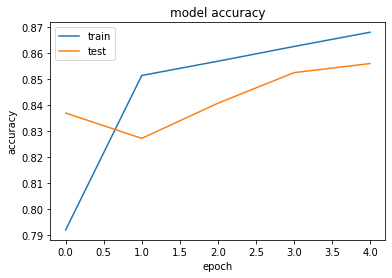

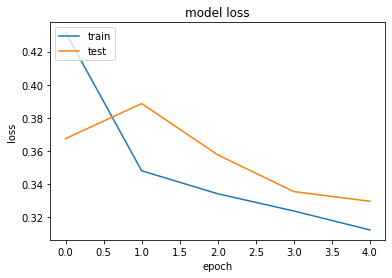

In [188]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [189]:
score = model.evaluate(test_padded, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.3408 - accuracy: 0.8476
Test Score: 0.34077194333076477
Test Accuracy: 0.847599983215332


In [190]:
class_prediction_lstm=[]
for x in range(len(test_padded)):
  result = model.predict(test_padded[x].reshape(1,test_padded.shape[1]))
  if result>0.5:
    class_prediction_lstm.append(1)
  else:
    class_prediction_lstm.append(0)

class_prediction_lstm = np.array(class_prediction_lstm)

In [191]:
accuracy_score_lstm = metrics.accuracy_score(class_prediction_lstm, y_test)
print('Accuracy of the LSTM based Classifier:',accuracy_score_lstm*100,'%')

Accuracy of the LSTM based Classifier: 84.76 %


## Get predictions for random examples

In [192]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

In [193]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
print(model.predict(padded))

[[0.64529353]
 [0.20575187]
 [0.124392  ]]


In [194]:
review_prediction = model.predict(padded)
for i,val in enumerate(review_prediction):
  i=i+1
  if val>0.5:
    print('Review',i,'is positive')
  else:
    print('Review',i,'is negative')

Review 1 is positive
Review 2 is negative
Review 3 is negative
